<a href="https://colab.research.google.com/github/roscibely/Sistemas-de-controle-Lab/blob/main/Realimenta%C3%A7%C3%A3o_de_Estado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Controle no Espaço de Estados: Realimentação de Estados (Seguidor de Referência)

In [1]:
!pip install control #Necessário para fazer o download da biblioteca control

     |████████████████████████████████| 348kB 7.6MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=b7b69a04de940e78db7044e6d20c7a29431c2df5f8e36aa3155dcea1d35eddb3
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


## 1. Bibliotecas necessárias

In [21]:
import numpy as np
import control as control
import matplotlib.pyplot as plt
from control.matlab import *
import cmath

## 2. Definição do modelo no espaço de estado

In [3]:
#Definindo os parametros do sistema 
a1 = 0.17813919765      # Diâmetro do orifício do tanque (cm²) 
a2 = a1
A1 = 15.5179            # Área da base do tanque (cm²) 
A2 = A1
g = 981                 # Aceleração gravitacional (cm/s²) 
km = 3*4.5              # Constante do fluxo da bomba cm³/s.V 
L20 = 15                # Constante da ODEs 
L10 = ( (a2**2)/(a1**2) ) * L20
#####################  Espaço de estado #######################################
A11 = -1*(a1/A1)*np.sqrt(g/(2*L10))
A12 = 0
A21 = (a1/A2)*np.sqrt(g/(2*L10))
A22 = -1*(a2/A2)*np.sqrt(g/(2*L20))
B1 = (km/A1)
B2 = 0.0
A=np.matrix([[A11, A12],
             [A21, A22]])
B=np.matrix([[B1],
            [B2]]) 
C=np.array([[0, 1]])
D=0
print('A=',A, '\nB=',B)

A= [[-0.06564481  0.        ]
 [ 0.06564481 -0.06564481]] 
B= [[0.86996307]
 [0.        ]]


In [6]:
# Matrizes aumentadas
Aa= np.matrix([[0, 0, -1],
               [0, A11, A12],
              [0, A21, A22]              
])
Bb=np.matrix([[0],
              [B1],
            [B2]])

Cc=np.array([[0, 0, 1]])

### 2.1 Pólos do sistema em malha aberta 

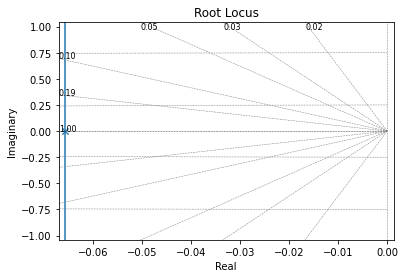

In [42]:
TF= ss2tf(A,B,C,D)
r=control.root_locus(TF)

## 3. Calculo do controlador utilizando o método de Ackermann

In [22]:
K = acker(Aa, Bb, [-1,complex(-0.3,0.1), complex(-0.3,-0.1)])
print(K)

[[-1.75105086  1.6882445  10.49365453]]


### 3.1 Pólos do sistema em malha fechada com o controlador

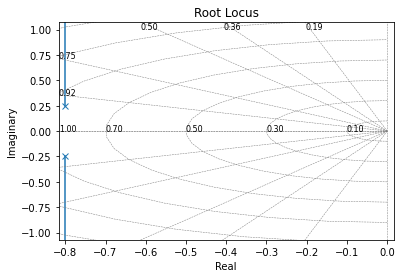

In [41]:
TF_MalhaFechada= ss2tf(A - B*K[:,1:3], B, C, D)
r=control.root_locus(TF_MalhaFechada)

## 4. Simulação

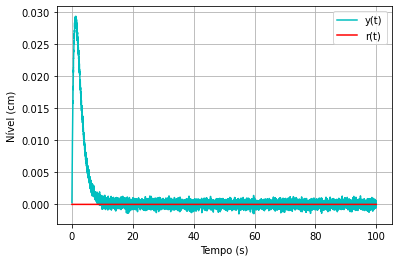

In [ ]:
clsys = ss(Aa - Bb*K, Bb, Cc, D) # Sistema em malha fechada 
tf = 100.00                  # Tempo de simulação em segundos 
dt = 0.01                    # Tempo de amostragem
t = np.arange(0, tf, dt)
r = np.zeros(t.shape)
ruido=np.random.normal(0, 0.0004, len(t))
T, Y, X = control.forced_response(clsys, t, r, X0=[0.1, 1, 0])
plt.figure()
plt.plot(T,Y+ruido, 'c')
plt.plot(t,r, 'r')
plt.legend(["y(t)", "r(t)"])
plt.ylabel('Nível (cm)')
plt.xlabel('Tempo (s)')
plt.grid('True')

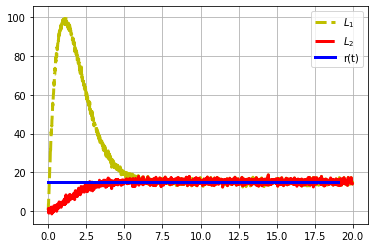

In [ ]:
from scipy.integrate import odeint


tf = 20                      # Tempo de simulação em segundos 
dt = 0.01                    # Tempo de amostragem
t = np.arange(0, tf, dt)

#Referencia 
h1ref=np.zeros(tf)
h1ref[0:tf]=15


def sistema(y,t):
  x1,x2 = y #Estados do sistema
  a1 = 0.17813919765      # Diâmetro do orifício do tanque (cm²) 
  a2 = a1
  A1 = 15.5179            # Área da base do tanque (cm²) 
  A2 = A1
  g = 981                 # Aceleração gravitacional (cm/s²) 
  km = 3*4.5              # Constante do fluxo da bomba cm³/s.V 
  L20 = 15                # Constante da ODEs 
  L10 = ( (a2**2)/(a1**2) ) * L20
  u = -K.item(0)*(150-x2) -(K.item(1)*x1 + K.item(2)*x2) #Sinal de controle
  dydt = []
  dydt=[ -1*(a1/A1)*np.sqrt(g/(2*L10))*x1 + (km/A1)*u, (a1/A2)*np.sqrt(g/(2*L10))*x1 -(a2/A2)*np.sqrt(g/(2*L20))*x2 ] # Dinamica
  return dydt


n=np.random.normal(0, 1, len(t))
x0=[0, 0.1]
s = odeint(sistema,x0,t) 
fig = plt.figure()
plt.plot(t,s[:,0]+n,'y--', linewidth=3.0)
plt.plot(t,s[:,1]+n,'r-.', linewidth=3.0)
plt.plot(h1ref,'b', linewidth=3.0)
plt.legend(['$L_1$', '$L_2$', 'r(t)'])
plt.grid(True)